<a href="https://colab.research.google.com/github/mverbytska/amazon-reviews-sentiment-analysis/blob/main/amazon_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Reviews Sentiment Analysis
### Used dataset: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
## Research purposes:
* Understand the nature of the reviews unlabeled data
* Consider the application of *K-Means* clustering technique to text data using word embeddings obtained from *tf-idf* vectorising
* Discover solutions for sentiment analysis implementation using a rule-based sentiment analyzer named *VADER*, as well as a transformer-based pre-trained language model *RoBERTa*

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import  Counter
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import contractions
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.special import softmax
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import logging
import torch.nn as nn

## 0. Data Understanding

In [ ]:
raw_data = pd.read_csv('drive/MyDrive/Colab Notebooks/datasets/Reviews.csv')\
.drop(columns=['Id'])
raw_data.head()

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
raw_data.shape

(568454, 9)

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   ProductId               568454 non-null  object
 1   UserId                  568454 non-null  object
 2   ProfileName             568428 non-null  object
 3   HelpfulnessNumerator    568454 non-null  int64 
 4   HelpfulnessDenominator  568454 non-null  int64 
 5   Score                   568454 non-null  int64 
 6   Time                    568454 non-null  int64 
 7   Summary                 568427 non-null  object
 8   Text                    568454 non-null  object
dtypes: int64(4), object(5)
memory usage: 39.0+ MB


In [ ]:
raw_data.isna().sum()

ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64

In [ ]:
raw_data['Score'].unique()

array([5, 1, 4, 2, 3])

## 1. Data Cleaning and Text Processing

#### Rename columns to make their names standardized

In [ ]:
standardized_col_names = [col.lower() for col in list(raw_data.columns)]
raw_data.columns = standardized_col_names
cols_to_rename = {'productid': 'product_id',
                 'userid': 'user_id',
                 'profilename': 'profile_name',
                 'helpfulnessnumerator': 'helpfulness_numerator',
                 'helpfulnessdenominator': 'helpfulness_denominator'}
raw_data.rename(columns=cols_to_rename, inplace=True)
raw_data.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### Lowercase all text in 'summary' and 'text' columns

In [ ]:
lowercased_data = raw_data.copy(deep=True)
lowercased_data[['summary', 'text']] = lowercased_data[['summary', 'text']] \
.applymap(lambda x: x.lower() if isinstance(x, str) else x)

# view changes
lowercased_data['text'][420]

'i was not expecting to like these cookies as much as i do. i like chocolate chip cookies well enough, but i really prefer a soft cookie to crisp ones. i have to say these famous amos cookies have pertty much turned me around. the cookies are rich and have that depth of flavor that comes from quality ingredients. the chips are real chocolate and melt redilly in your mouth creating a moist experience while chewing. these are truly great cookies.'

#### Remove punctuation from 'summary' and 'text'

In [ ]:
non_alphb_pattern = r'[^\w\s]'
lowercased_data[['summary', 'text']] = lowercased_data[['summary', 'text']] \
.replace(non_alphb_pattern, '', regex=True)

In [ ]:
# view changes
lowercased_data['text'][3549]

'somehow i feel healtier eating these things instead of peanuts i dont know why either also unlike peanuts i can limit my intake to a handful and not the whole bag'

#### Contractions handling

In [ ]:
lowercased_data[['summary', 'text']] = lowercased_data[['summary', 'text']]\
.applymap(
    lambda x: ' '.join(contractions.fix(word) if isinstance(word, str) \
                       else str(word) for word in str(x).split())
)

In [24]:
#view changes
lowercased_data['text'][3549]

'somehow i feel healtier eating these things instead of peanuts i do not know why either also unlike peanuts i can limit my intake to a handful and not the whole bag'

#### Dropping rows with *None* values in 'summary' column
As original dataset contains a large number of samples, we may assume that removing 27 rows with *None* values in *'summary'* column will not affect the model's generalization ability

In [25]:
clean_data = lowercased_data[lowercased_data['summary'].notnull()]
clean_data.head()

,product_id,user_id,profile_name,helpfulness_numerator,helpfulness_denominator,score,time,summary,text
0,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,good quality dog food,i have bought several of the vitality canned d...
1,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,not as advertised,product arrived labeled as jumbo salted peanut...
2,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,delight says it all,this is a confection that has been around a fe...
3,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,cough medicine,if you are looking for the secret ingredient i...
4,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,great taffy,great taffy at a great price there was a wide ...


## 2. Exploratory Data Analysis

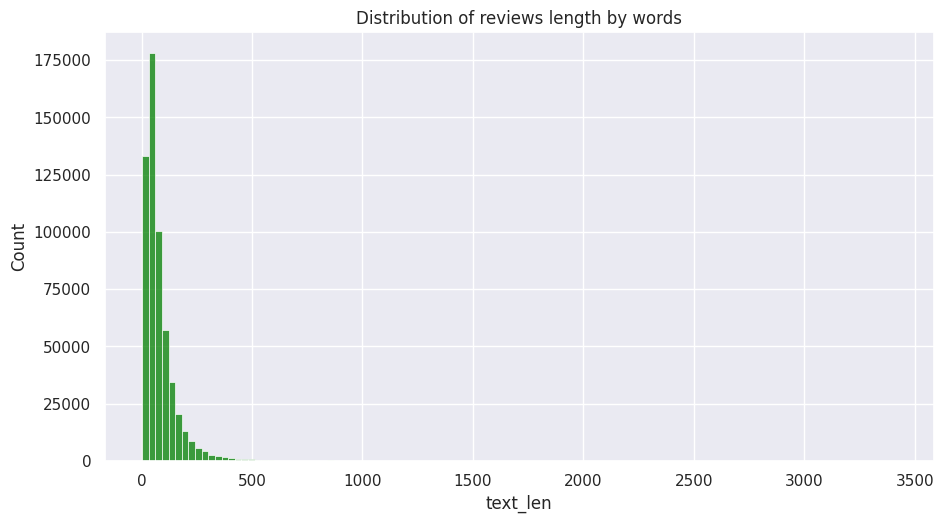

In [26]:
clean_data['text_len'] = clean_data['text'].apply(lambda x: len(str(x).split()))
sns.set(rc={'figure.figsize':(10.7, 5.57)})
sns.histplot(data=clean_data,
             x='text_len',
             binwidth=30,
             color='green') \
.set(title='Distribution of reviews length by words')
plt.show()

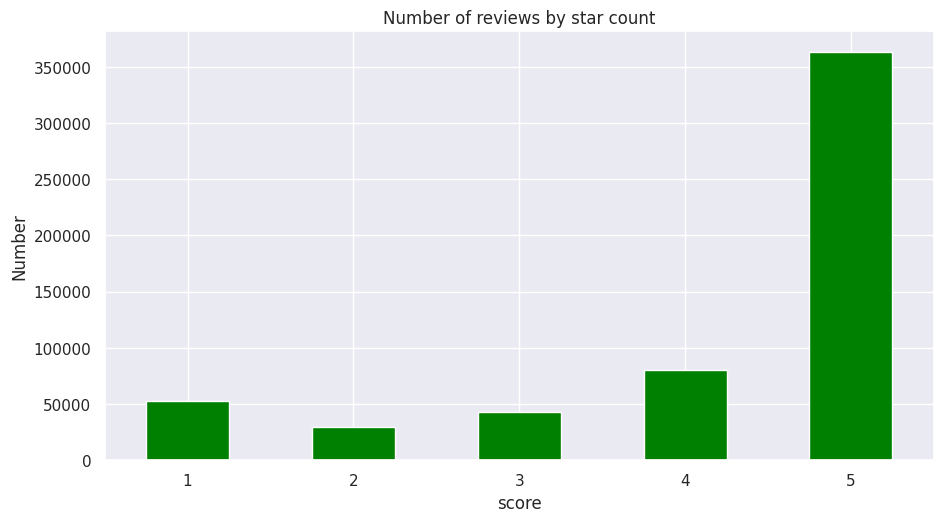

In [27]:
clean_data['score'].value_counts().sort_index() \
.plot(kind='bar', color='green')
plt.xticks(rotation=0)
plt.ylabel('Number')
plt.title('Number of reviews by star count')
plt.show()

#### Helper function

In [28]:
def generate_word_cloud(*score_values):

    """
    Generates and shows word cloud for text from Summary column using rows based on
    specific given values for Score column.

    Params:
        *score_values(list of ints): Values of the 'Score' column used to filter rows.

    Returns:
        None

    Raises:
        ValueError: If no parameters given, list is empty or values from list are not from range [0; 5].
    """
    if score_values and all(0 <= score <= 5 for score in score_values):
        words = clean_data.loc[clean_data['score'].isin(score_values), 'summary'].str.cat(sep=' ')
        wordcloud = WordCloud(background_color='white').generate(words)
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.show()
    else:
        raise ValueError('Non-empty integer list in range [0; 5] must be provided')

#### The most frequent words from possibly positive reviews

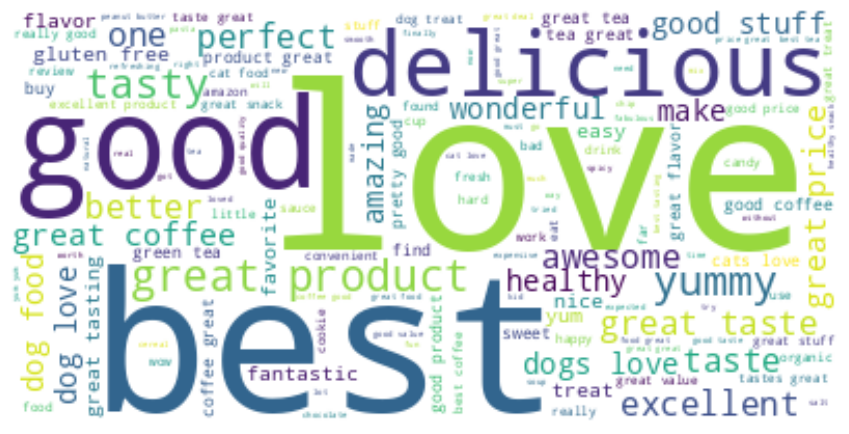

In [29]:
generate_word_cloud(*[4, 5])

#### The most frequent words from possibly neutral reviews

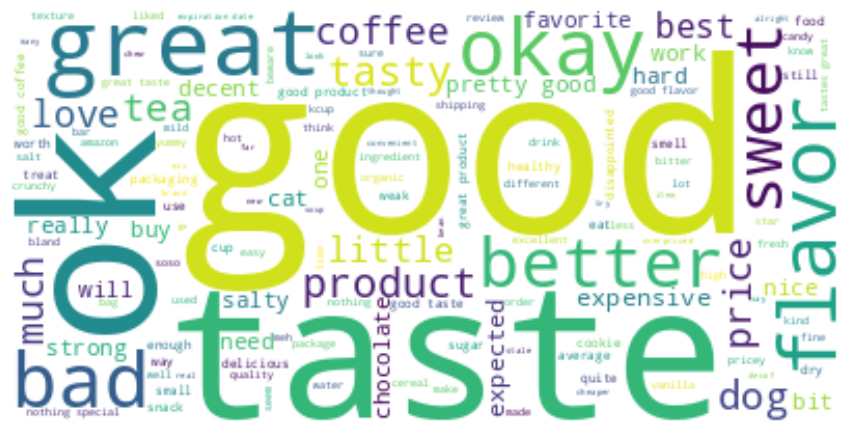

In [30]:
generate_word_cloud(*[3])

#### The most frequent words from possibly negative reviews

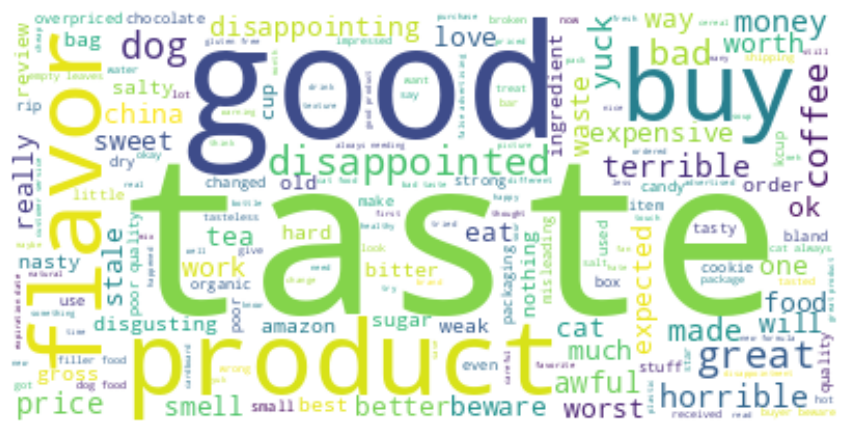

In [31]:
generate_word_cloud(*[1, 2])

In [42]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

#### Define stop words

In [43]:
stop_words = set(stopwords.words('english'))
not_stopwords = {'no','not'}
stop_words = stop_words-not_stopwords

#### Helper function

In [44]:
def find_and_plot_top_words(df: pd.DataFrame, col_name: str, n: int, for_stopwords=False):
    """
    Creates a Counter object from dictionary with words and their frequencies within a given column with text data.
    Builds and shows a barplot with specified number of top words according to their frequencies.

    Params:
        Args:
            df(pd.DataFrame): pre-defined DataFrame object.
            col_name(str): name of the text data column we are interested in.
            n(int): number of top-frequent words to include in the plot.
        Kwargs:
            for_stopwords(bool): to determine whether we are interested in actual words or words from stopwords set (default: False).

    Returns:
        None

    Raises:
        ValueError: when the column with a specified name is not found in a given dataframe; when n <= 0.
    """
    if col_name in df.columns:
        if n > 0:
            current_corpus = [word for sublist in df[col_name].str.split().tolist() for word in sublist]
            counter = Counter(current_corpus)
            if not for_stopwords:
                filtered_freq_counter = Counter({word: freq for word, freq in counter.items() if word not in stop_words})
                top = filtered_freq_counter.most_common(n)
                top_words, top_freqs = zip(*top)

                sns.barplot(x=top_freqs, y=top_words, hue=top_words, legend=False)
                plt.show()
            else:
                stop_words_freq_counter = Counter({word: freq for word, freq in counter.items() if word in stop_words})
                top = stop_words_freq_counter.most_common(n)
                stop_words_top, stop_words_top_freqs = zip(*top)

                sns.barplot(x=stop_words_top, y=stop_words_top_freqs)
                plt.show()
        else:
            raise ValueError(f'n must be a positive integer')
    else:
        raise ValueError(f'Given column is not found in this DataFrame')

#### Plot top-20 most frequent words over *'text'* column

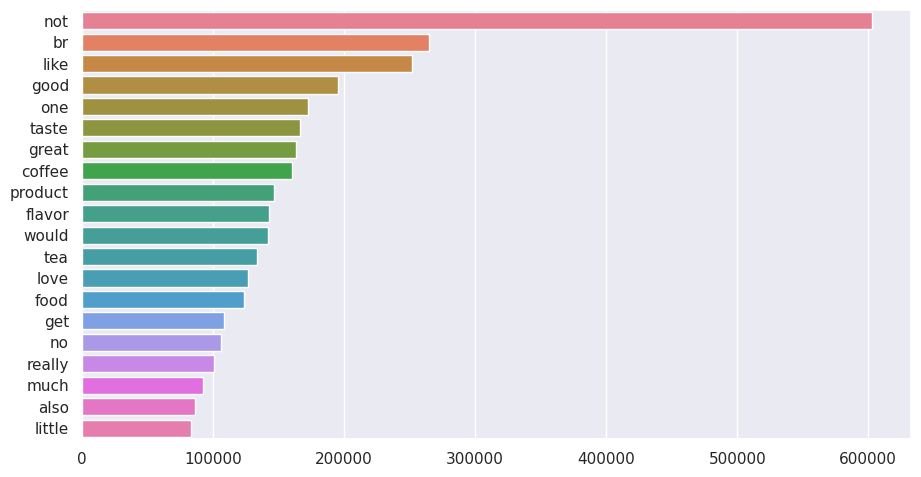

In [45]:
find_and_plot_top_words(clean_data, 'text', 20, False)

#### Plot top-20 most frequent words over 'summary' columns

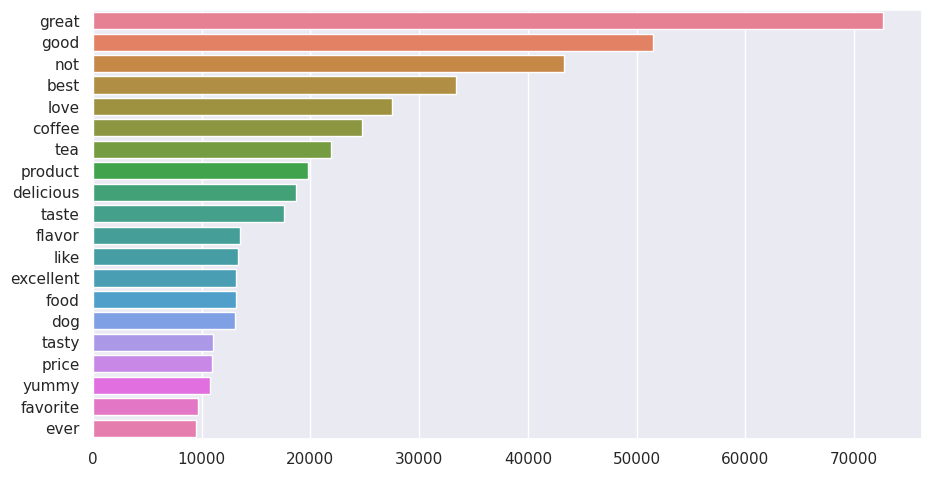

In [46]:
find_and_plot_top_words(clean_data, 'summary', 20, False)

#### Plot top-10 most frequent stopwords in *'text'* column

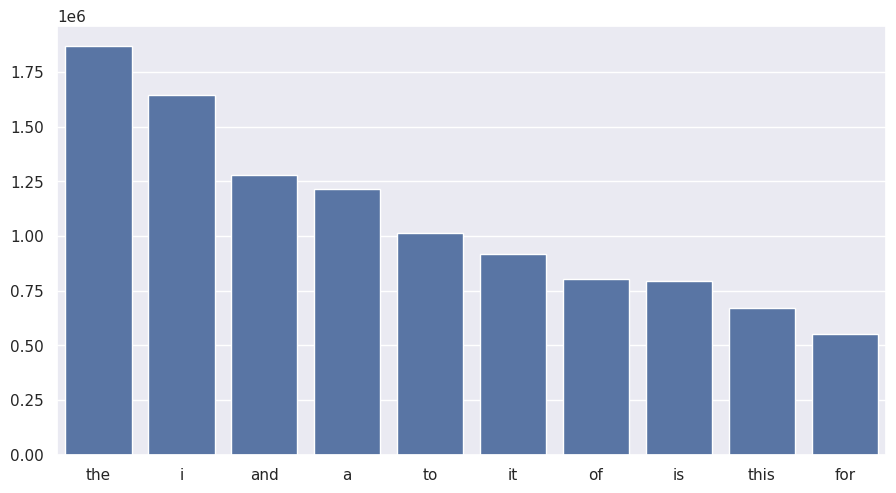

In [47]:
find_and_plot_top_words(clean_data, 'text', 10, True)

#### Plot top-10 most frequent stopwords in *'summary'* column

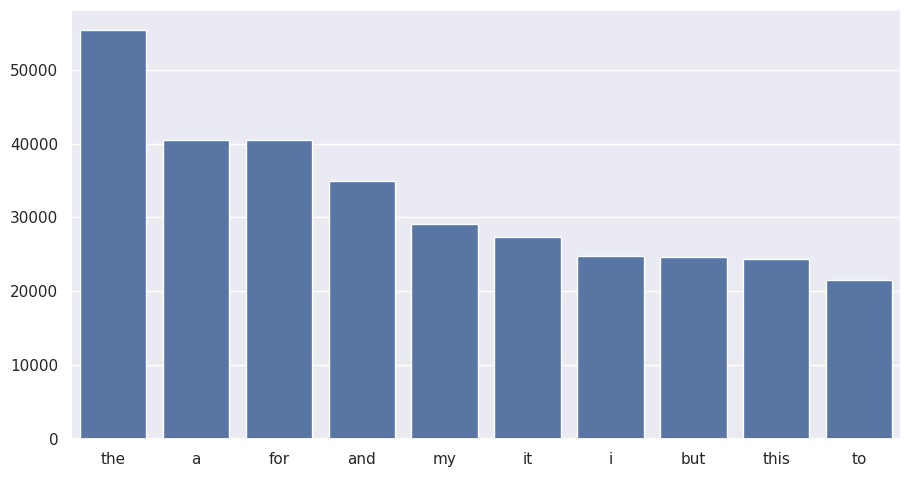

In [48]:
find_and_plot_top_words(clean_data, 'summary', 10, True)

## 3. Data Preprocessing

#### Tokenization

In [36]:
def tokenization_of(text: str):
    return word_tokenize(text)

In [39]:
clean_data['tokenized_summary'] = clean_data['summary'].apply(tokenization_of)
clean_data['tokenized_text'] = clean_data['text'].apply(tokenization_of)
clean_data['tokenized_text'][3549]

['somehow',
 'i',
 'feel',
 'healtier',
 'eating',
 'these',
 'things',
 'instead',
 'of',
 'peanuts',
 'i',
 'do',
 'not',
 'know',
 'why',
 'either',
 'also',
 'unlike',
 'peanuts',
 'i',
 'can',
 'limit',
 'my',
 'intake',
 'to',
 'a',
 'handful',
 'and',
 'not',
 'the',
 'whole',
 'bag']

#### Remove stop words

In [40]:
def remove_stopwords(text):
    return [word for word in text if word not in stop_words]

In [49]:
clean_data['tokenized_summary_without_stopwords'] = clean_data['tokenized_summary'].apply(remove_stopwords)
clean_data['tokenized_text_without_stopwords'] = clean_data['tokenized_text'].apply(remove_stopwords)
clean_data['tokenized_text_without_stopwords'][3549]

['somehow',
 'feel',
 'healtier',
 'eating',
 'things',
 'instead',
 'peanuts',
 'not',
 'know',
 'either',
 'also',
 'unlike',
 'peanuts',
 'limit',
 'intake',
 'handful',
 'not',
 'whole',
 'bag']

#### Lemmatization

In [50]:
wnl = WordNetLemmatizer()
def lemmatization_of(text):
    return [wnl.lemmatize(word, pos='v') for word in text]

In [52]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [54]:
clean_data['lemmatized_summary'] = clean_data['tokenized_summary_without_stopwords'].apply(lemmatization_of)
clean_data['lemmatized_text'] = clean_data['tokenized_text_without_stopwords'].apply(lemmatization_of)
clean_data['lemmatized_text'][3549]

['somehow',
 'feel',
 'healtier',
 'eat',
 'things',
 'instead',
 'peanuts',
 'not',
 'know',
 'either',
 'also',
 'unlike',
 'peanuts',
 'limit',
 'intake',
 'handful',
 'not',
 'whole',
 'bag']

#### Final data cleaning

In [55]:
columns_to_save = ['product_id', 'score', 'summary', 'text', 'lemmatized_summary', 'lemmatized_text']
clean_data = clean_data[columns_to_save]

In [56]:
clean_data.head()

,product_id,score,summary,text,lemmatized_summary,lemmatized_text
0,B001E4KFG0,5,good quality dog food,i have bought several of the vitality canned d...,"[good, quality, dog, food]","[buy, several, vitality, can, dog, food, produ..."
1,B00813GRG4,1,not as advertised,product arrived labeled as jumbo salted peanut...,"[not, advertise]","[product, arrive, label, jumbo, salt, peanutst..."
2,B000LQOCH0,4,delight says it all,this is a confection that has been around a fe...,"[delight, say]","[confection, around, centuries, light, pillowy..."
3,B000UA0QIQ,2,cough medicine,if you are looking for the secret ingredient i...,"[cough, medicine]","[look, secret, ingredient, robitussin, believe..."
4,B006K2ZZ7K,5,great taffy,great taffy at a great price there was a wide ...,"[great, taffy]","[great, taffy, great, price, wide, assortment,..."


#### Add a column with words from both summary and text columns

In [57]:
def union_lists(l1: list, l2: list):
    return l1+l2

In [58]:
clean_data['full_review'] = clean_data.apply(lambda x: union_lists(x['lemmatized_summary'], x['lemmatized_text']), axis=1)
clean_data.head()

,product_id,score,summary,text,lemmatized_summary,lemmatized_text,full_review
0,B001E4KFG0,5,good quality dog food,i have bought several of the vitality canned d...,"[good, quality, dog, food]","[buy, several, vitality, can, dog, food, produ...","[good, quality, dog, food, buy, several, vital..."
1,B00813GRG4,1,not as advertised,product arrived labeled as jumbo salted peanut...,"[not, advertise]","[product, arrive, label, jumbo, salt, peanutst...","[not, advertise, product, arrive, label, jumbo..."
2,B000LQOCH0,4,delight says it all,this is a confection that has been around a fe...,"[delight, say]","[confection, around, centuries, light, pillowy...","[delight, say, confection, around, centuries, ..."
3,B000UA0QIQ,2,cough medicine,if you are looking for the secret ingredient i...,"[cough, medicine]","[look, secret, ingredient, robitussin, believe...","[cough, medicine, look, secret, ingredient, ro..."
4,B006K2ZZ7K,5,great taffy,great taffy at a great price there was a wide ...,"[great, taffy]","[great, taffy, great, price, wide, assortment,...","[great, taffy, great, taffy, great, price, wid..."


#### Make an extraction from original data to obtain 500 random samples

Throughout the analysis, the decision was made to perform further analysis on a subset with random samples from original data, as the dimension of the vectorized data is too large for the computing abilities of the machine the project is performed on

In [60]:
n_samples = 500
random_sample = clean_data['full_review'].sample(n=n_samples, random_state=42)
random_sample.head()

165256    [crunchy, good, glutenfree, sandwich, cookies,...
231465    [great, kitty, treat, cat, love, treat, ever, ...
427827    [coffee, taste, little, less, expect, tend, mu...
433954    [miniwheats, big, first, frost, miniwheats, or...
70260     [great, taste, want, congratulate, graphic, ar...
Name: full_review, dtype: object

#### tf-idf vectorizing

In [61]:
doc = [' '.join(review) for review in random_sample]

In [62]:
tf_idf_v = TfidfVectorizer(max_df=0.98, min_df=2)
tf_idf_data = tf_idf_v.fit_transform(doc)

In [63]:
tf_idf_data.shape

(500, 1737)

## 4. Try applying K-Means clusterization on these data

#### Figuring out the neccessary number of clusters using the Silhouette method

In [ ]:
clusters_n_range = range(2, 501)
silhouette_avgs = []
for n in clusters_n_range:
  kmeans = KMeans(n_clusters=n, init='k-means++', n_init=1)
  kmeans.fit(tf_idf_data)
  cluster_labels = kmeans.labels_

  silhouette_avgs.append(silhouette_score(tf_idf_data, cluster_labels))

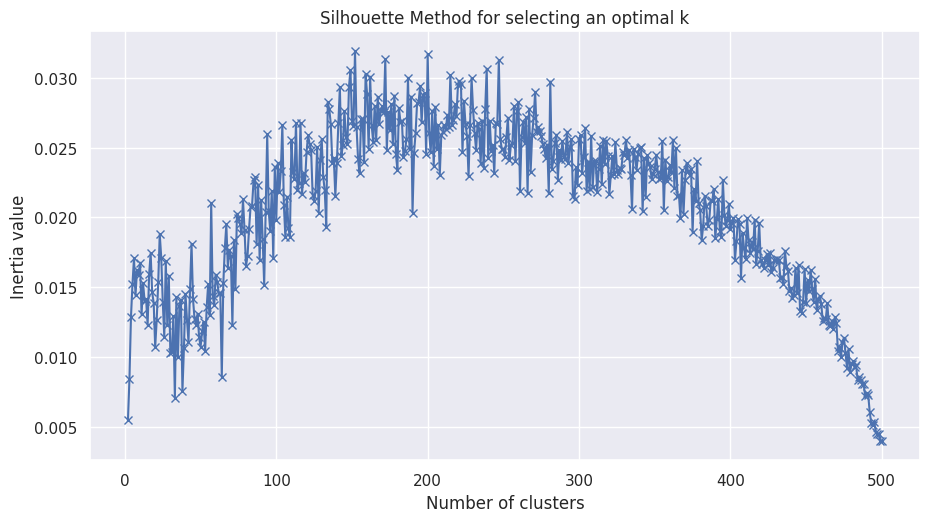

In [67]:
plt.plot(clusters_n_range, silhouette_avgs,'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia value')
plt.title('Silhouette Method for selecting an optimal k')
plt.show()

### Conclusions:
K-Means clusterization can be a solution to deal with data of such a nature. However, even for a relatively small subset of the data in 500 samples the result of the *silhouette average values* analysis is not accurate enough to use this technique for further investigation: from the plot it can be seen that the reached *maximum values* on y-axis by the curve are approximately *0.03-0.0325*. The obtained values give us the understanding of existent *clusters overlapping*, and it might not lead us to correct insights from the clusterized data, because, for instance, there would be data points being belonged to several clusters simultaneously. Thus, there is a need to use a more complex text classification model.  

## 5. VADER Sentiment Analysis

#### Make an extraction of the first 5000 samples for *'summary_and_text'* series

In [ ]:
summary_and_text = clean_data['summary'][:5000] + ' '+ clean_data['text'][:5000]
summary_and_text

0       good quality dog food i have bought several of...
1       not as advertised product arrived labeled as j...
2       delight says it all this is a confection that ...
3       cough medicine if you are looking for the secr...
4       great taffy great taffy at a great price there...
                              ...                        
4995    the cavemen must have been wealthy i really wa...
4996    these cookies need work you can make your own ...
4997    okay in a pinch not great the cookies came sea...
4998    they are good except for the rainforest flavor...
4999    great healthy snack i love these cookies i am ...
Length: 5000, dtype: object

#### Helper function

In [ ]:
def remove_stopwords_from_column(text: str):
    '''
    Remove stopwords from a column with strings and return cleaned text in the form of string

    Params:
        text: string we are observing and want to remove the stopwords from.

    Returns:
        str: string containing words that have passed the check for being stopwords only

    Raises:
        None
    '''
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

#### Remove stopwords from text in the *'summary_and_text'* column

In [ ]:
summary_and_text = summary_and_text.apply(remove_stopwords_from_column)
summary_and_text

0       good quality dog food bought several vitality ...
1       not advertised product arrived labeled jumbo s...
2       delight says confection around centuries light...
3       cough medicine looking secret ingredient robit...
4       great taffy great taffy great price wide assor...
                              ...                        
4995    cavemen must wealthy really wanted like theseb...
4996    cookies need work make home not impressed cook...
4997    okay pinch not great cookies came sealed seem ...
4998    good except rainforest flavor taste good not l...
4999    great healthy snack love cookies paleo diet ri...
Length: 5000, dtype: object

#### VADER Sentiment Analysis

In [ ]:
sent_ia = SentimentIntensityAnalyzer()
polarity_scores = []
for sentence in summary_and_text:
    polarity_scores.append(sent_ia.polarity_scores(sentence))

In [ ]:
print(clean_data['full_review'][1])
print(polarity_scores[1])

['not', 'advertise', 'product', 'arrive', 'label', 'jumbo', 'salt', 'peanutsthe', 'peanuts', 'actually', 'small', 'size', 'unsalted', 'not', 'sure', 'error', 'vendor', 'intend', 'represent', 'product', 'jumbo']
{'neg': 0.084, 'neu': 0.818, 'pos': 0.097, 'compound': 0.0762}


#### Resulting dataframe

In [ ]:
vaders = pd.DataFrame(polarity_scores)
vaders

,neg,neu,pos,compound
0,0.000,0.504,0.496,0.9565
1,0.084,0.818,0.097,0.0762
2,0.152,0.532,0.316,0.9042
3,0.000,0.868,0.132,0.4404
4,0.000,0.339,0.661,0.9661
...,...,...,...,...
4995,0.040,0.699,0.260,0.9343
4996,0.058,0.704,0.238,0.9525
4997,0.206,0.673,0.121,-0.6884
4998,0.227,0.520,0.254,0.5861


#### Addition of corresponding reviews to the dataframe

In [ ]:
summary_and_text.name = 'summary_and_text'
vader_data = vaders.merge(summary_and_text, right_index=True, left_index=True)
vader_data.head()

,neg,neu,pos,compound,summary_and_text
0,0.000,0.504,0.496,0.9565,good quality dog food bought several vitality ...
1,0.084,0.818,0.097,0.0762,not advertised product arrived labeled jumbo s...
2,0.152,0.532,0.316,0.9042,delight says confection around centuries light...
3,0.000,0.868,0.132,0.4404,cough medicine looking secret ingredient robit...
4,0.000,0.339,0.661,0.9661,great taffy great taffy great price wide assor...


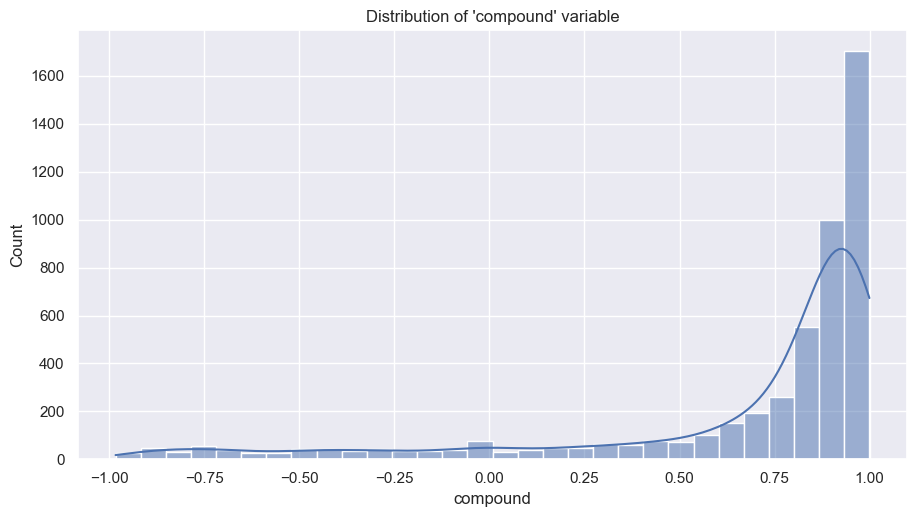

In [ ]:
sns.histplot(data=vader_data, x='compound', bins=30, kde=True).set(title='Distribution of \'compound\' variable')
plt.show()

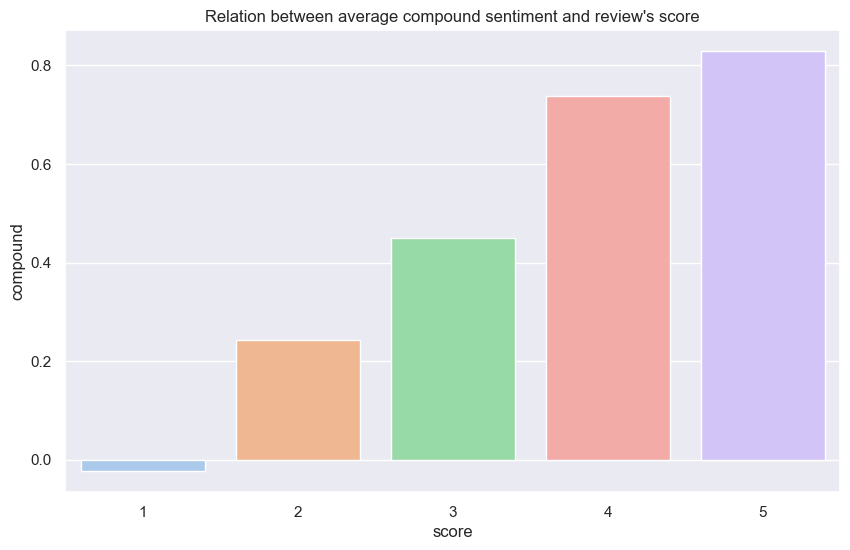

In [ ]:
vader_data['score'] = clean_data['score'][:5000]
aveg_sentiment_by_score = vader_data.groupby('score')['compound'].mean().reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=aveg_sentiment_by_score,
            x='score',
            y='compound',
            hue='score',
            palette='pastel',
            legend=False).set(title='Relation between average compound sentiment and review\'s score')
plt.show()

#### Barplot for each polarity category

In [ ]:
def plot_polarity_barplots(polarities: list):
    '''
    Plot barplots for polarities in a specified list.

    Params:
        polarities: list of strings that are names for columns in a df for plotting.

    Returns:
        None.

    Raises:
        ValueError: if the given list is empty.
    '''
    if polarities:
        n = len(polarities)
        fig, axs = plt.subplots(1, n, figsize=(5*n, 6))
        for i in range(n):
            axs[i] = sns.barplot(data=vader_data,
                     x='score',
                     y=polarities[i],
                     hue='score',
                     palette='pastel',
                     legend=False,
                     ax=axs[i]).set(title=f'Score VS {polarities[i]} polarity')
    else:
        raise ValueError('List must be non-null')

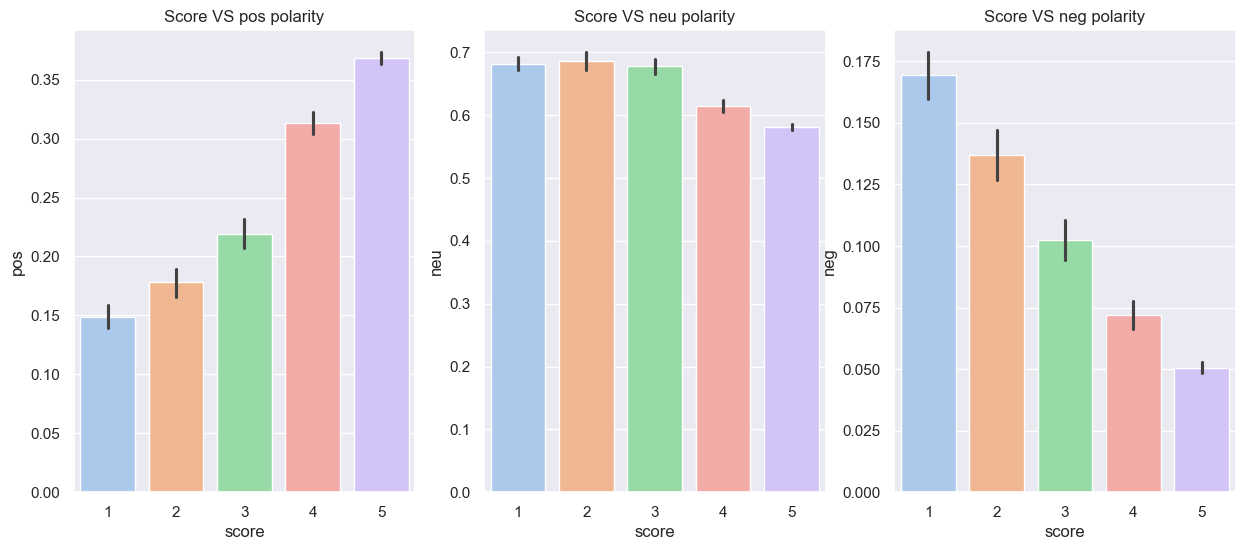

In [ ]:
vader_polarities = ['pos', 'neu', 'neg']
plot_polarity_barplots(vader_polarities)

## 6. RoBERTa Pre-Trained Model Sentiment Analysis

In [ ]:
model_name = f'cardiffnlp/twitter-roberta-base-sentiment-latest'
model_tokenizer = AutoTokenizer.from_pretrained(model_name)
logging.getLogger("transformers.modeling_utils").setLevel(logging.ERROR)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

#### Helper function

In [ ]:
MAX_TOKENS=510
def roberta_analyze_sentiments(text: str, softmax_temperature=1.0):
    '''
    Tokenizes given text using previously created tokenizer, and then calculates polarity scores for it.

    Params:
        Args:
            text: string sentiment polarities of which we are interested in.
        Kwargs:
            softmax_temperature(int, default=1.0): a hyperparameter value to control the randomness of predictions before applying softmax.

    Returns:
        dict: keys: polarity names; values: polarity values
    '''
    if not text.strip():
        return {'pos': 0.0, 'neu': 0.0, 'neg': 0.0}
    try:
        tokenized_text = model_tokenizer(text, max_length=MAX_TOKENS, truncation=True, return_tensors='pt')
    except Exception as e:
        print(f'Encounter the error while tokenizing the text {e}')
        return {'pos': 0.0, 'neu': 0.0, 'neg': 0.0}
    with torch.no_grad():
        res = model(**tokenized_text)
        logits = res.logits[0]
        polarity_scores = softmax(logits.detach().numpy() / softmax_temperature)
    scores_dict = {'pos': np.round(polarity_scores[2], 2),
                   'neu': np.round(polarity_scores[1], 2),
                   'neg': np.round(polarity_scores[0], 2)}
    return scores_dict

#### Tokenize reviews and calculate polarities for each one

In [ ]:
roberta_polarity_dicts = summary_and_text.apply(roberta_analyze_sentiments)

In [ ]:
roberta_df = pd.DataFrame.from_records(roberta_polarity_dicts,index=range(len(roberta_polarity_dicts)))
roberta_df['review'] = summary_and_text
roberta_df.head()

,pos,neu,neg,review
0,0.94,0.05,0.01,good quality dog food bought several vitality ...
1,0.02,0.35,0.63,not advertised product arrived labeled jumbo s...
2,0.90,0.10,0.00,delight says confection around centuries light...
3,0.39,0.56,0.04,cough medicine looking secret ingredient robit...
4,0.99,0.01,0.00,great taffy great taffy great price wide assor...


#### Calculate the overall polarity of each review by its assigned probabilities

In [ ]:
polarities_weights = torch.tensor([1, 0, -1])
roberta_probs = torch.tensor(roberta_df[['pos', 'neu', 'neg']].values)
overall_polarity = polarities_weights * roberta_probs
overall_polarity = overall_polarity.sum(dim=-1)
polarity = nn.Tanh()(overall_polarity)
roberta_df['review_polarity'] = polarity.numpy()
roberta_df.head()

,pos,neu,neg,review,review_polarity
0,0.94,0.05,0.01,good quality dog food bought several vitality ...,0.730594
1,0.02,0.35,0.63,not advertised product arrived labeled jumbo s...,-0.544127
2,0.90,0.10,0.00,delight says confection around centuries light...,0.716298
3,0.39,0.56,0.04,cough medicine looking secret ingredient robit...,0.336376
4,0.99,0.01,0.00,great taffy great taffy great price wide assor...,0.757362


#### Comparison of overall reviews' polarities distribution

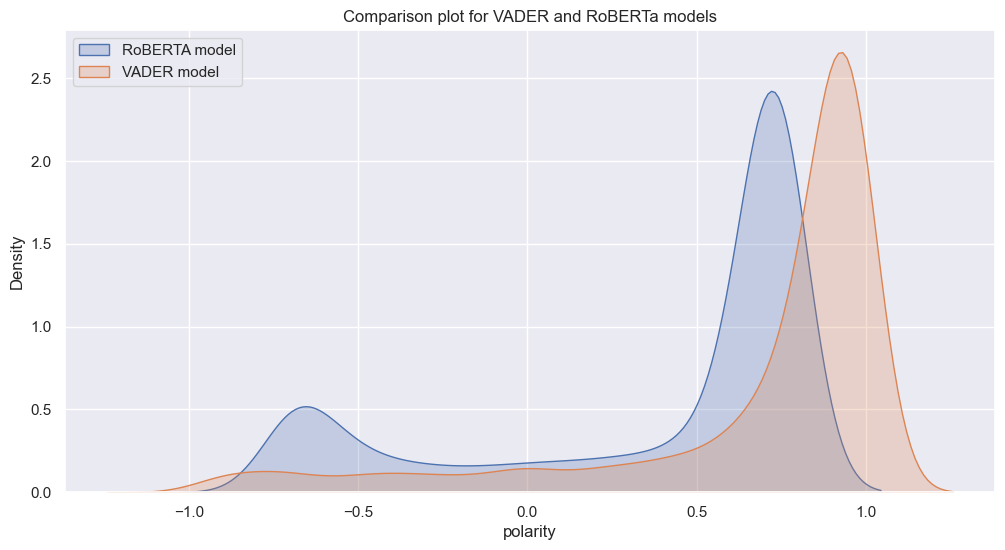

In [ ]:
plt.figure(figsize=(12,6))
sns.kdeplot(data=roberta_df, x='review_polarity', fill=True)
sns.kdeplot(data=vader_data, x='compound', fill=True)
plt.xlabel('polarity')
plt.title('Comparison plot for VADER and RoBERTa models')
plt.legend(['RoBERTA model', 'VADER model'], loc='upper left')
plt.show()

#### Helper function

In [ ]:
def assign_sentiment_label_for(df: pd.DataFrame, column_name: str) -> dict:
    '''
    Divides reviews assigning sentiment labels to them.

    Params:
        df: a dataframe with our data.
        column_name: a specified column with overall sentiment score.

    Returns:
        dict: a dictionary with keys – indexes of rows with corresponding reviews, values – assigned sentiment label.

    raises:
        ValueError: if given column is not found in this dataframe.
    '''
    if column_name in df:
        labels = ['Positive', 'Neutral', 'Negative']
        labels_dict = {}
        for i in range(len(df)):
            if -1 <=df[column_name][i]<= -0.25:
                labels_dict[i] = labels[2]
            elif -0.25 <= df[column_name][i] <= 0.25:
                labels_dict[i] = labels[1]
            elif 0.25 <= df[column_name][i] <= 1:
                labels_dict[i] = labels[0]
        return labels_dict
    else:
        raise ValueError('Specified column is not found in this DataFrame')

In [ ]:
vader_sentiment_labels = pd.Series(assign_sentiment_label_for(vader_data, 'compound'))
roberta_sentiment_labels = pd.Series(assign_sentiment_label_for(roberta_df, 'review_polarity'))

#### Comparison of the number of reviews assigned to each polarity

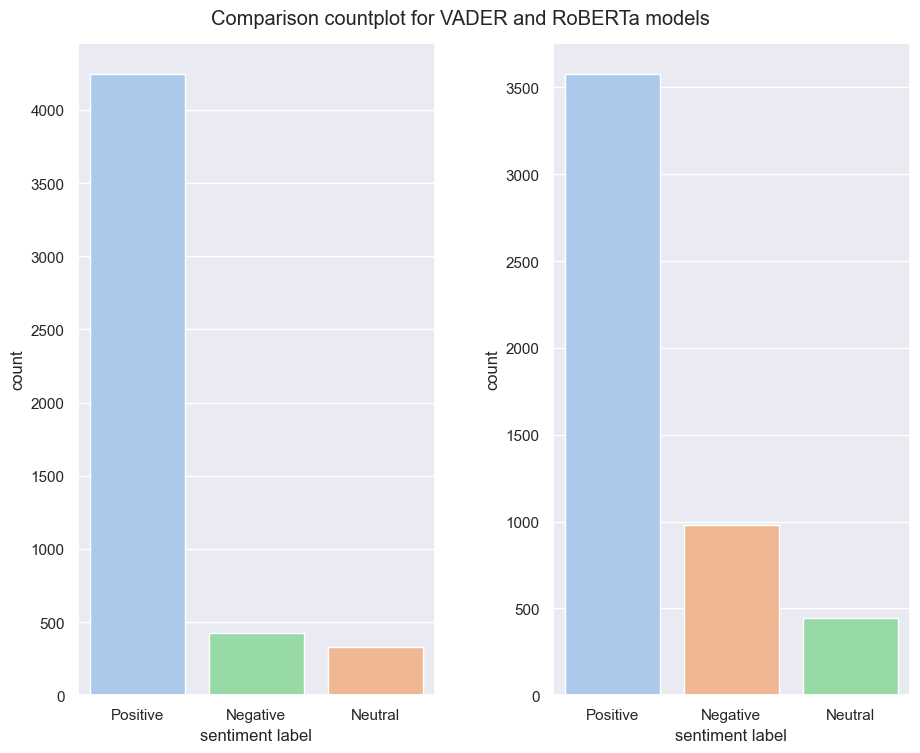

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 8))
vader_sentiment_labels_values = vader_sentiment_labels.value_counts()
vader_order = vader_sentiment_labels_values.index.tolist()

roberta_sentiment_labels_values = roberta_sentiment_labels.value_counts()
roberta_order = roberta_sentiment_labels_values.index.tolist()
sns.countplot(x=vader_sentiment_labels,
              order=vader_order,
              hue=vader_sentiment_labels,
              palette='pastel',
              legend=False,
              ax=axs[0]).set(xlabel='sentiment label')
sns.countplot(x=roberta_sentiment_labels,
              order=roberta_order,
              hue=roberta_sentiment_labels,
              palette='pastel',
              legend=False,
              ax=axs[1]).set(xlabel='sentiment label')
plt.tight_layout(pad=3.0)
plt.suptitle('Comparison countplot for VADER and RoBERTa models')
plt.show()

### Conclusions:
At this project stage 2 techniques have been performed: *VADER* and *RoBERTa*. The obtained results are similar, and this can bee seen from their kernel density plots. Apart from that, after dividing reviews into the groups with corresponding sentiment labels, and then plotting them, we can see that *RoBERTa* model *is more robust to negative* sentiments, and recognizes them better then the VADER model: by the latter one, there are less than 500 reviews labeled as 'negative' out of 5000 examined samples, while RoBERTa model marked almost 1000 reviews in that way, making the difference twice as much. Therefore, RoBERTa outperforms as a sentiment analyzer when we are interested in robust results. However, for large datasets it may consume a lot of time to analyze the input data by RoBERTa model, as well as we should handle the limitation of length for one sample for a particular model we are currently using.
In conclusion, RoBERTa pre-trained model performs sufficiently well for Amazon reviews data, but as it is usually working longer than the VADER model, the latter may be considered adequate enough to work with as well, especially for the data of not too complex semantic relationships.